# Variazione prezzo NFT

#### Importazione librerie

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import os

### nft_trades dataset import

In [45]:
# Definire i tipi di dati per ogni colonna
dtype = {
    'contract_address': str,
    'transaction_hash': str,
    'num_items': int,
    'seller': str,
    'buyer': str,
    'token_id': str,
    'avg_price': float,
    'currency': str,
    'currency_address': str,
    'usd_amount': float,
    'platform': str
}

# Leggere il file CSV
nft_trades_ds = pd.read_csv("../datasets/nfts/nft_trades.csv", chunksize=100000, dtype=dtype, lineterminator='\n', low_memory=False, parse_dates=['date'])
nft_trades_df = pd.concat(nft_trades_ds)

nft_trades_df.info()
nft_trades_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507678 entries, 0 to 507677
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              507678 non-null  datetime64[ns]
 1   contract_address  507678 non-null  object        
 2   transaction_hash  507678 non-null  object        
 3   num_items         507678 non-null  int64         
 4   seller            507678 non-null  object        
 5   buyer             507678 non-null  object        
 6   token_id          507678 non-null  object        
 7   avg_price         507678 non-null  float64       
 8   currency          507678 non-null  object        
 9   currency_address  31601 non-null   object        
 10  usd_amount        507678 non-null  float64       
 11  platform          507678 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 46.5+ MB


(507678, 12)

In [46]:
# we assiacure that there are no cells with null values in the date and text columns
nft_trades_df.dropna(axis=0 ,subset=['date', 'token_id', 'avg_price', 'transaction_hash', 'seller', 'buyer', 'currency', 'platform'],inplace = True)
nft_trades_df.reset_index(drop= True,inplace=True)
nft_trades_df.shape

(507678, 12)

In [47]:
# Check for null values
null_values = nft_trades_df.isnull().sum()
print("Null values in each column:\n", null_values)

# Check for duplicates
duplicate_rows = nft_trades_df.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)

Null values in each column:
 date                     0
contract_address         0
transaction_hash         0
num_items                0
seller                   0
buyer                    0
token_id                 0
avg_price                0
currency                 0
currency_address    476077
usd_amount               0
platform                 0
dtype: int64
Number of duplicate rows: 0


In [48]:
# Data cleaning 
nft_trades_df.drop_duplicates(inplace = True)
nft_trades_df.reset_index(drop=True,inplace=True)
nft_trades_df.shape

(507678, 12)

In [49]:
# Setting dataset column types
#nft_trades_df = nft_trades_df.convert_dtypes()
#nft_trades_df.dtypes

In [50]:
# Convertire la colonna 'date' in formato datetime
nft_trades_df['date'] = pd.to_datetime(nft_trades_df['date'])

# Selezionare le righe con data successiva al 15 novembre 2020
new_nft_trades = nft_trades_df[nft_trades_df['date'] > '2020-11-15']

# Ordinare il DataFrame per token_id e data
filtrate_nft_trades_sorted = new_nft_trades.sort_values(by=['token_id', 'date'])

## Calcolo e identificazione delle variazioni di prezzo

In [51]:
#print(filtrate_nft_trades_sorted.groupby('token_id').size())

In [52]:
# Calcolare le variazioni di prezzo per ogni token_id
filtrate_nft_trades_sorted['price_change'] = filtrate_nft_trades_sorted.groupby('token_id')['avg_price'].diff()

# Identificare le variazioni positive e negative consecutive
filtrate_nft_trades_sorted['price_trend'] = (
    filtrate_nft_trades_sorted['price_change']
    .apply(lambda x: 'positivo' if x > 0 else ('negativo' if x < 0 else 'nessuna variazione'))
)

# Raggruppare le variazioni consecutive
filtrate_nft_trades_sorted['trend_change'] = (
    (filtrate_nft_trades_sorted['price_trend'] != filtrate_nft_trades_sorted['price_trend'].shift())
    .astype(int)
    .cumsum()
)

## Aggregazione e Filtraggio delle Variazioni di Prezzo

In [53]:
# Raggruppare per token_id e trend_change per trovare le date di inizio e fine delle variazioni
grouped = filtrate_nft_trades_sorted.groupby(['token_id', 'trend_change', 'price_trend']).agg(
    data_inizio=('date', 'first'),
    data_fine=('date', 'last'),
    prezzo_inizio=('avg_price', 'first'),
    prezzo_fine=('avg_price', 'last')
).reset_index()

# Filtrare casi con prezzo_inizio o prezzo_fine uguali a 0
grouped = grouped[(grouped['prezzo_inizio'] != 0) & (grouped['prezzo_fine'] != 0)]

# Calcolare la percentuale di variazione del prezzo, ignorando i casi con nessuna variazione di prezzo
grouped['percentuale_variazione'] = grouped.apply(
    lambda row: (row['prezzo_fine'] - row['prezzo_inizio']) / row['prezzo_inizio'] * 100
    if row['prezzo_inizio'] != row['prezzo_fine'] else 0, axis=1
)

# Filtrare solo le variazioni di prezzo, escludendo "nessuna variazione"
price_changes = grouped[grouped['price_trend'] != 'nessuna variazione']


## Calcolo dei Prezzi Medi e Filtraggio delle Variazioni Significative

In [54]:
# Calcolare il prezzo medio per ogni token_id
average_prices = filtrate_nft_trades_sorted.groupby('token_id')['avg_price'].mean().reset_index()
average_prices.rename(columns={'avg_price': 'avg_price_avg'}, inplace=True)

# Unire il prezzo medio con il DataFrame delle variazioni di prezzo
price_changes_with_avg = price_changes.merge(average_prices, on='token_id', how='left')

# Selezionare le colonne desiderate
result = price_changes_with_avg[['data_inizio', 'data_fine', 'token_id', 'price_trend', 'trend_change', 'prezzo_inizio', 'prezzo_fine', 'avg_price_avg', 'percentuale_variazione']]

# Definire la soglia per la percentuale di variazione
threshold = 90  # Ad esempio, il 150%

# Filtrare i risultati che superano la soglia in positivo o negativo
result_filtered = result[(result['percentuale_variazione'] > threshold) | (result['percentuale_variazione'] < -threshold)]


## Selezione dei Top 10 Token con Variazioni Positive e Negative

In [55]:
# Selezionare i top 10 token con variazioni positive e negative
top_nft_positivi = result_filtered.nlargest(10, 'percentuale_variazione')
top_nft_negativi = result_filtered.nsmallest(10, 'percentuale_variazione')

# Unire i due DataFrame
top_nft_tokens_uniti = pd.concat([top_nft_positivi, top_nft_negativi])


## Visualizzazione delle Variazioni di Prezzo

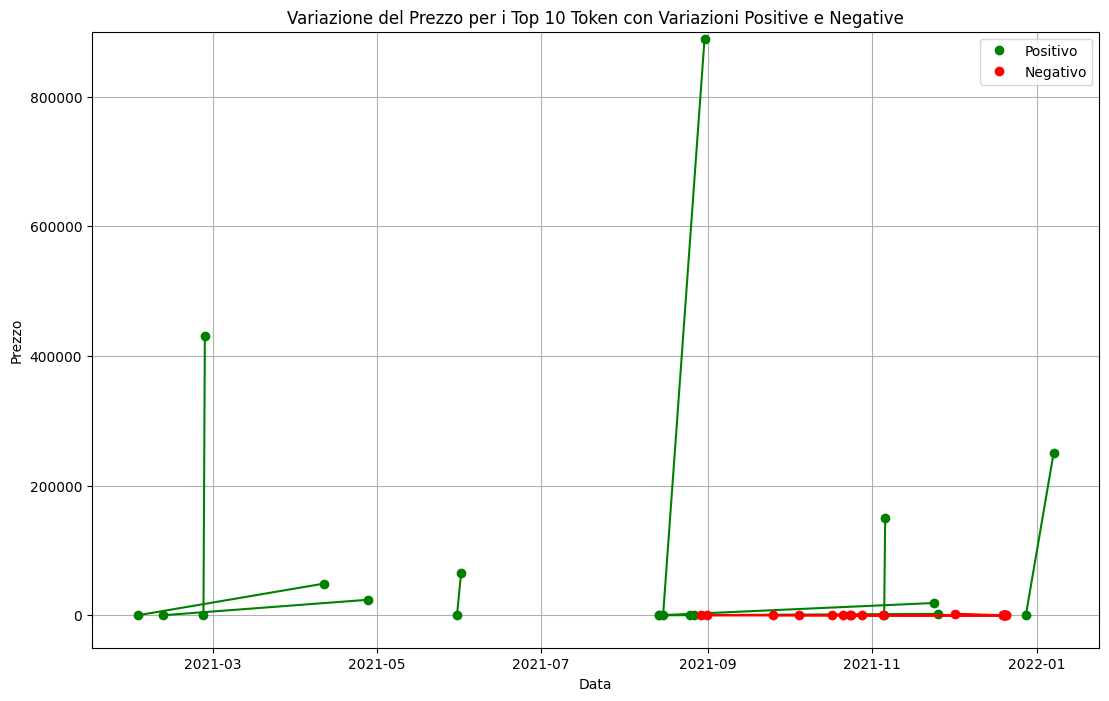

In [56]:
# Impostare la dimensione della figura
plt.figure(figsize=(13, 8))

# Impostare i limiti dell'asse y
plt.ylim(-50000, 900000)

# Iterare sui token e tracciare le variazioni di prezzo
for _, row in top_nft_tokens_uniti.iterrows():
    color = 'green' if row['percentuale_variazione'] > 0 else 'red'
    plt.plot([row['data_inizio'], row['data_fine']], [row['prezzo_inizio'], row['prezzo_fine']], color=color, marker='o')

# Aggiungere etichette e titolo
plt.xlabel('Data')
plt.ylabel('Prezzo')
plt.title('Variazione del Prezzo per i Top 10 Token con Variazioni Positive e Negative')
plt.grid(True)

# Aggiungere una legenda personalizzata
plt.plot([], [], 'go', label='Positivo')
plt.plot([], [], 'ro', label='Negativo')
plt.legend(loc='best')

# Mostrare il grafico
plt.show()

## Analisi delle Variazioni per Unit Time

In [57]:
# Calcoliamo la durata in secondi per le variazioni positive
top_nft_positivi['durata'] = (top_nft_positivi['data_fine'] - top_nft_positivi['data_inizio']).dt.total_seconds()

# Calcoliamo la variazione percentuale per unità di tempo
top_nft_positivi['variazione_per_sec'] = top_nft_positivi['percentuale_variazione'] / top_nft_positivi['durata']

# Ordiniamo i risultati per variazione_per_sec in ordine decrescente
top_nft_positivi = top_nft_positivi.sort_values(by='variazione_per_sec', ascending=False)

# Visualizziamo i risultati
top_5_pos = top_nft_positivi.head(5)
print(top_5_pos)

# Calcoliamo la durata in secondi per le variazioni negative
top_nft_negativi['durata'] = (top_nft_negativi['data_fine'] - top_nft_negativi['data_inizio']).dt.total_seconds()

# Calcoliamo la variazione percentuale per unità di tempo
top_nft_negativi['variazione_per_sec'] = top_nft_negativi['percentuale_variazione'] / top_nft_negativi['durata']

# Ordiniamo i risultati per variazione_per_sec in ordine crescente
top_nft_negativi = top_nft_negativi.sort_values(by='variazione_per_sec', ascending=True)

# Visualizziamo i risultati
top_5_neg = top_nft_negativi.head(2)
print(top_5_neg)

               data_inizio           data_fine token_id price_trend  \
90408  2021-08-15 07:05:16 2021-08-30 16:33:32     6563    positivo   
55849  2021-11-05 09:46:35 2021-11-05 18:42:28     4037    positivo   
8180   2021-02-25 14:23:29 2021-02-26 02:48:36    12247    positivo   
121339 2021-05-30 18:06:57 2021-06-01 06:39:14     8898    positivo   
132173 2021-08-25 04:45:19 2021-08-26 19:24:15     9728    positivo   

        trend_change  prezzo_inizio  prezzo_fine  avg_price_avg  \
90408         152777          0.130     888888.0   37043.645984   
55849         100401          1.400     150000.0    5360.899107   
8180           17188          3.000     430000.0   63690.436667   
121339        197896          0.640      64842.0    2176.416933   
132173        214046          0.006        269.0      11.790029   

        percentuale_variazione     durata  variazione_per_sec  
90408             6.837599e+08  1330096.0          514.068082  
55849             1.071419e+07    32153.0 

## Salvataggio dei Risultati in File CSV

In [15]:
# Percorso della cartella "dataframes"
dataframes_path = '../dataframes'

# Salvataggio del dataframe top_10_positivi e top_10_negativi in un file CSV nella cartella 'dataframes'
top_nft_negativi.to_csv(os.path.join(dataframes_path, 'top_nft_negativi_df.csv'), index=False)
top_nft_positivi.to_csv(os.path.join(dataframes_path, 'top_nft_positivi_df.csv'), index=False)